![MLU Logo](../../data/MLU_Logo.png)

# <a name="0">Responsible AI - Disparate Impact</a>

This notebook shows how to quantify disparate impact and covers the implementation of a basic disparate impact remover. We will use a Logistic Regression classifier to predict whether an individuals' income is $\leq$ 50k or not using US census data.

__Dataset:__ 
You will download a dataset for this exercise using [folktables](https://github.com/zykls/folktables). Folktables provides an API to download data from the American Community Survey (ACS) Public Use Microdata Sample (PUMS) files which are managed by the US Census Bureau. The data itself is governed by the terms of use provided by the Census Bureau. For more information, see the [Terms of Service](https://www.census.gov/data/developers/about/terms-of-service.html).

__ML Problem:__ 
Ultimately, the goal will be to predict whether an individual's income is above \\$50,000. We will filter the ACS PUMS data sample to only include individuals above the age of 16, who reported usual working hours of at least 1 hour per week in the past year, and an income of at least \\$100. The threshold of \\$50,000 was chosen so that this dataset can serve as a comparable substitute to the [UCI Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult). The income threshold can be changed easily to define new prediction tasks.

1. <a href="#1">Read the dataset</a>
2. <a href="#2">Data Processing</a>
    * <a href="#21">Exploratory Data Analysis</a>
    * <a href="#22">Select features to build the model</a>
    * <a href="#23">Feature Transformation</a>
    * <a href="#24">Train - Validation - Test Datasets</a>
    * <a href="#25">Data processing with Pipeline and ColumnTransformer</a>
3. <a href="#3">Train (and Tune) a Classifier</a>
4. <a href="#4">Test the Classifier</a>

This notebook assumes an installation of the SageMaker kernel `conda_pytorch_p39`. In addition, libraries from a requirements.txt need to be installed:

In [1]:
!pip install --no-deps -U -q -r ../../requirements.txt

In [ ]:
%%capture

# Reshaping/basic libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

# Operational libraries
import sys
from tqdm import tqdm

sys.path.append("..")

# Fairness libraries
from folktables.acs import *
from folktables.folktables import *
from folktables.load_acs import *
from aif360.datasets import BinaryLabelDataset, Dataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import DisparateImpactRemover

# Jupyter(lab) libraries
import warnings

warnings.filterwarnings("ignore")

## 1. <a name="1">Read the dataset</a>
(<a href="#0">Go to top</a>)

To read in the dataset, we will be using [folktables](https://github.com/zykls/folktables) which provides access to the US Census dataset. Folktables contains predefined prediction tasks but also allows the user to specify the problem type.

The US Census dataset distinguishes between household and individuals. To obtain data on individuals, we use `ACSDataSource` with `survey=person`. The feature names for the US Census data follow the same distinction and use `P` for `person` and `H` for `household`, e.g.: `AGEP` refers to age of an individual.

In [3]:
income_features = [
    "AGEP",  # age individual
    "COW",  # class of worker
    "SCHL",  # educational attainment
    "MAR",  # marital status
    "OCCP",  # occupation
    "POBP",  # place of birth
    "RELP",  # relationship
    "WKHP",  # hours worked per week past 12 months
    "SEX",  # sex
    "RAC1P",  # recorded detailed race code
    "PWGTP",  # persons weight
    "GCL",  # grand parents living with grandchildren
    "SCH",  # school enrollment
]

# Define the prediction problem and features
ACSIncome = folktables.BasicProblem(
    features=income_features,
    target="PINCP",  # total persons income
    target_transform=lambda x: x > 50000,
    group="RAC1P",
    preprocess=adult_filter,  # applies the following conditions; ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    postprocess=lambda x: x,  # applies post processing, e.g. fill all NAs
)

# Initialize year, duration ("1-Year" or "5-Year") and granularity (household or person)
data_source = ACSDataSource(survey_year="2018", horizon="1-Year", survey="person")
# Specify region (here: California) and load data
ca_data = data_source.get_data(states=["CA"], download=True)
# Apply transformation as per problem statement above
ca_features, ca_labels, ca_group = ACSIncome.df_to_numpy(ca_data)

# Convert numpy array to dataframe
df = pd.DataFrame(
    np.concatenate((ca_features, ca_labels.reshape(-1, 1)), axis=1),
    columns=income_features + [">50k"],
)

# For further modelling you want to use only 2 groups
df = df[df["RAC1P"].isin([6, 8])].copy(deep=True)

## 2. <a name="2">Data Processing</a>
(<a href="#0">Go to top</a>)

### 2.1 <a name="21">Exploratory Data Analysis</a>
(<a href="#2">Go to Data Processing</a>)

We look at number of rows, columns, and some simple statistics of the dataset.

In [4]:
# Print the first five rows
# NaN means missing data
df.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PWGTP,GCL,SCH,>50k
0,30.0,6.0,14.0,1.0,9610.0,6.0,16.0,40.0,1.0,8.0,32.0,2.0,1.0,0.0
27,23.0,2.0,21.0,5.0,2545.0,207.0,17.0,20.0,2.0,6.0,35.0,NaN,3.0,0.0
33,18.0,1.0,16.0,5.0,9610.0,6.0,17.0,8.0,2.0,6.0,33.0,NaN,2.0,0.0
46,40.0,1.0,15.0,3.0,4140.0,303.0,16.0,22.0,1.0,8.0,38.0,2.0,1.0,0.0
49,18.0,1.0,18.0,5.0,725.0,6.0,17.0,12.0,2.0,6.0,60.0,NaN,2.0,0.0


In [5]:
# Check how many rows and columns we have in the data frame
print("The shape of the dataset is:", df.shape)

The shape of the dataset is: (55502, 14)


In [6]:
# Let's see the data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55502 entries, 0 to 195664
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    55502 non-null  float64
 1   COW     55502 non-null  float64
 2   SCHL    55502 non-null  float64
 3   MAR     55502 non-null  float64
 4   OCCP    55502 non-null  float64
 5   POBP    55502 non-null  float64
 6   RELP    55502 non-null  float64
 7   WKHP    55502 non-null  float64
 8   SEX     55502 non-null  float64
 9   RAC1P   55502 non-null  float64
 10  PWGTP   55502 non-null  float64
 11  GCL     41987 non-null  float64
 12  SCH     55502 non-null  float64
 13  >50k    55502 non-null  float64
dtypes: float64(14)
memory usage: 6.4 MB


We can clearly see that all columns are numerical (`dtype = float64`). However, when checking the column headers (and information at top of the notebook), we should notice that we are actually dealing with multimodal data. We expect to see a mix of categorical, numerical and potentially even text information.

Let's cast the features accordingly. We start by creating list for each feature type.

In [7]:
categorical_features = [
    "COW",
    "SCHL",
    "MAR",
    "OCCP",
    "POBP",
    "RELP",
    "SEX",
    "GCL",
    "SCH",
]

sensitive_attribute = "RAC1P"

numerical_features = ["AGEP", "WKHP", "PWGTP"]

In [8]:
# We cast categorical features to `category`
df[categorical_features] = df[categorical_features].astype("object")

# We cast the sensitive attribute as `category`
df[sensitive_attribute] = df[sensitive_attribute].astype("object")

# We cast numerical features to `int`
df[numerical_features] = df[numerical_features].astype("int")

Let's check with `.info()` again to make sure the changes took effect.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55502 entries, 0 to 195664
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    55502 non-null  int64  
 1   COW     55502 non-null  object 
 2   SCHL    55502 non-null  object 
 3   MAR     55502 non-null  object 
 4   OCCP    55502 non-null  object 
 5   POBP    55502 non-null  object 
 6   RELP    55502 non-null  object 
 7   WKHP    55502 non-null  int64  
 8   SEX     55502 non-null  object 
 9   RAC1P   55502 non-null  object 
 10  PWGTP   55502 non-null  int64  
 11  GCL     41987 non-null  object 
 12  SCH     55502 non-null  object 
 13  >50k    55502 non-null  float64
dtypes: float64(1), int64(3), object(10)
memory usage: 6.4+ MB


Looks good, so we can now separate model features from model target to explore them separately.

In [10]:
model_target = ">50k"
model_features = categorical_features + numerical_features + [sensitive_attribute]

print("Model features: ", model_features)
print("Model target: ", model_target)

Model features:  ['COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'SEX', 'GCL', 'SCH', 'AGEP', 'WKHP', 'PWGTP', 'RAC1P']
Model target:  >50k


In [11]:
# Double check that that target is not accidentally part of the features
model_target in model_features

False

All good here. We made sure that the target is not in the feature list. If we find the above statement showing `True` we need to remove the target by calling `model_features.remove(model_target)`.

Let's have a look at missing values next.


#### Missing values
The quickest way to check for missing values is to use `.isna().sum()`. This will provide a count of how many missing values we have. In fact, we can also see the count of missing values with `.info()` as it provided a count of non-null values.

In [12]:
# Show missing values
df.isna().sum()

AGEP         0
COW          0
SCHL         0
MAR          0
OCCP         0
POBP         0
RELP         0
WKHP         0
SEX          0
RAC1P        0
PWGTP        0
GCL      13515
SCH          0
>50k         0
dtype: int64

Before starting with the plots, let's have a look at how many unique instances we have per column. This helps us avoid plotting charts with hundreds of unique values. Let's filter for columns with fewer than 10 unique instances.

In [13]:
shortlist_fts = (
    df[model_features]
    .apply(lambda col: col.nunique())
    .where(df[model_features].apply(lambda col: col.nunique()) < 10)
    .dropna()
)

print(shortlist_fts)

COW      8.0
MAR      5.0
SEX      2.0
GCL      2.0
SCH      3.0
RAC1P    2.0
dtype: float64


#### Target distribution

Let's check our target distribution.

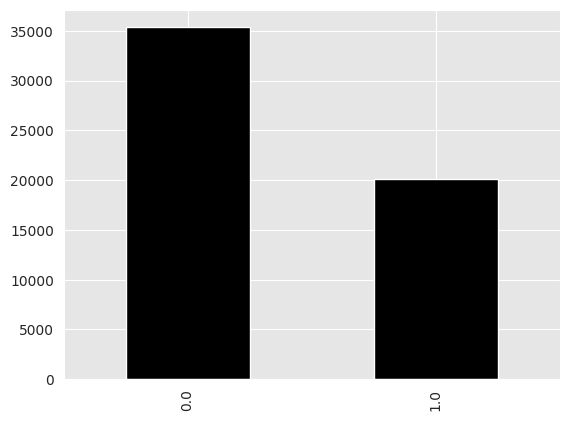

In [14]:
df[model_target].value_counts().plot.bar(color="black")
plt.show()

We notice that we are dealing with an imbalanced dataset. This means there are more examples for one type of results (here: 0; meaning individuals earning $\leq$ 50k). This is relevant for model choice and potential up-sampling or down-sampling to balance out the classes.

#### Feature distribution(s)

Let's now plot bar charts for the shortlist features of our dataset (as per above: shortlist - feature columns with less than 10 unique instance classes).

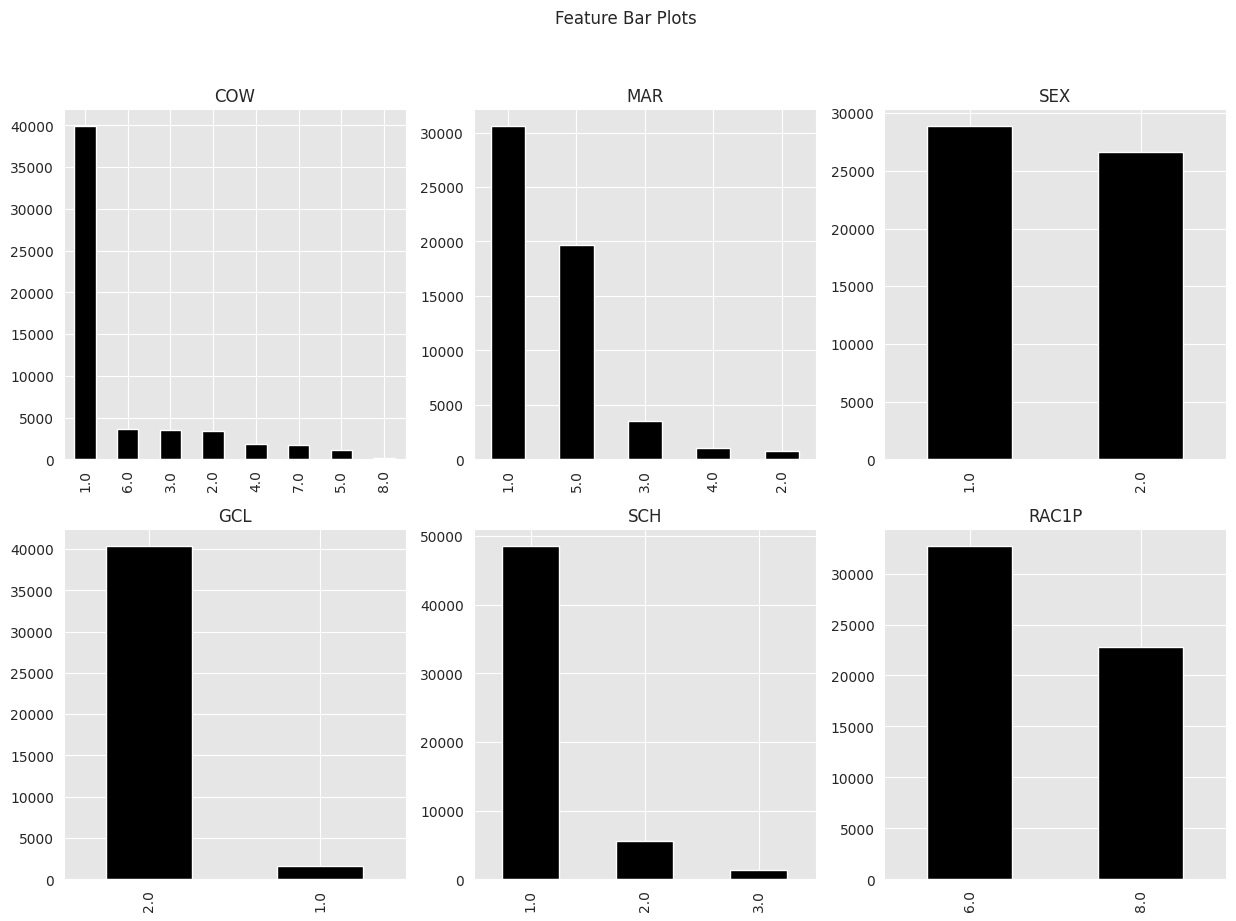

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle("Feature Bar Plots")

fts = range(len(shortlist_fts.index.tolist()))
for i, ax in zip(fts, axs.ravel()):
    df[shortlist_fts.index.tolist()[i]].value_counts().plot.bar(color="black", ax=ax)
    ax.set_title(shortlist_fts.index.tolist()[i])
plt.show()

### 2.2 <a name="22">Select features to build the model</a>
(<a href="#2">Go to Data Processing</a>)

During the extended EDA in the DATAPREP notebook, we learned that `GCL` is a feature that is equally present for both outcome types and also contains a lot of missing values. Therefore, we can drop it from the list of features we want to use for model build. We also drop `OCCP` and `POBP` as those features have too many unique categories.

In [16]:
to_remove = ["GCL", "OCCP", "POBP"]

# Drop to_remove features from the respective list(s) - if applicable
for ft in to_remove:
    if ft in model_features:
        model_features.remove(ft)
    if ft in categorical_features:
        categorical_features.remove(ft)
    if ft in numerical_features:
        numerical_features.remove(ft)

In [17]:
# Let's also clean up the dataframe and only keep the features and columns we need
df = df[model_features + [model_target]].copy(deep=True)

### 2.3 <a name="23">Feature transformation</a>
(<a href="#2">Go to Data Processing</a>)

In the paper [Certifying and Removing Disparate Impact](https://arxiv.org/pdf/1412.3756.pdf) a definition for Disparate Impact was introduced as the ratio of probability of positive outcomes for the disfavored group $(A=0)$ to probability of positive outcomes for the favored group $(A=1)$:  

$\large DI = \frac{Pr(Y=y|A=0)}{Pr(Y=y|A=1)}$
    

To be 'disparate impact free' the value calculated with the above equation needs to be $>$0.8.

In [18]:
# Create a Dataset construct for AIF360
binaryLabelDataset = BinaryLabelDataset(
    df=df,
    label_names=[">50k"],
    protected_attribute_names=["RAC1P"],
    favorable_label=1.0,
    unfavorable_label=0.0,
)

In [19]:
# We need to declare what the attribute value of the (un)privileged group is
priv_group = [{"RAC1P": 6}]
unpriv_group = [{"RAC1P": 8}]

Let's calculate the disparate impact (DI) value with the __AIF360__ inbuilt method `BinaryLabelDatasetMetric()`. You need to pass the data frame into the metric and then you can calculate DI by using `.disparate_impact()`.

In [20]:
# Let's look at the DI value
print(
    BinaryLabelDatasetMetric(
        binaryLabelDataset,
        unprivileged_groups=unpriv_group,
        privileged_groups=priv_group,
    ).disparate_impact()
)

0.4042999944218583


### 2.4 <a name="24">Train - Validation - Test Datasets</a>
(<a href="#2">Go to Data Processing</a>)

To get a training, test and validation set, we will use sklearn's [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function. 

In [21]:
train_data, test_data = train_test_split(
    df, test_size=0.1, shuffle=True, random_state=23
)

train_data, val_data = train_test_split(
    train_data, test_size=0.15, shuffle=True, random_state=23
)

# Print the shapes of the Train - Test Datasets
print(
    "Train - Test - Validation datasets shapes: ",
    train_data.shape,
    test_data.shape,
    val_data.shape,
)

Train - Test - Validation datasets shapes:  (42458, 11) (5551, 11) (7493, 11)


### 2.5 <a name="25">Data processing with Pipeline and ColumnTransformer</a>
(<a href="#2">Go to Data Processing</a>)

Let's build a data processing pipeline. We need pre-processing split per data type, and then combine everything back into a composite pipeline. To achieve this, we will use sklearns `Pipeline` and `ColumnTransformer`.

__Step 1 (set up pre-processing per data type):__
> For the numerical features pipeline, the __numerical_processor__ below, we impute missing values with the mean using sklearn's `SimpleImputer`, followed by a `MinMaxScaler` (don't have to scale features when using Decision Trees, but it's a good idea to see how to use more data transforms). If different processing is desired for different numerical features, different pipelines should be built - just like shown below for the two text features.

 > In the categorical features pipeline, the __categorical_processor__ below, we impute with a placeholder value and encode with sklearn's `OneHotEncoder`. If computing memory is an issue, it is a good idea to check categoricals' unique values, to get an estimate of many dummy features will be created by one-hot encoding. Note the __handle_unknown__ parameter that tells the encoder to ignore (rather than throw an error for) any unique value that might show in the validation/and or test set that was not present in the initial training set.
 
__Step 2 (combining pre-processing methods into a transformer):__ 
 > The selective preparations of the dataset features are then put together into a collective `ColumnTransformer`, to be finally used in a Pipeline along with an estimator. This ensures that the transforms are performed automatically on the raw data when fitting the model and when making predictions, such as when evaluating the model on a validation dataset via cross-validation or making predictions on a test dataset in the future.


In [22]:
### STEP 1 ###
##############

# Preprocess the numerical features
numerical_processor = Pipeline(
    [("num_imputer", SimpleImputer(strategy="mean")), ("num_scaler", MinMaxScaler())]
)
# Preprocess the categorical features
categorical_processor = Pipeline(
    [
        ("cat_imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("cat_encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

### STEP 2 ###
##############

# Combine all data preprocessors from above
data_processor = ColumnTransformer(
    [
        ("numerical_processing", numerical_processor, numerical_features),
        ("categorical_processing", categorical_processor, categorical_features),
    ],
    remainder="drop",
)

Now, we want to use the data processing pipeline to prepare the data before we perform the DI removal.

In [23]:
# Learn the transformation & extract feature names
data_processor.fit(train_data)

# To extract feature names we first need to fit the data processor as this will generate the one hot encoding
ft_names = numerical_features + list(
    data_processor.transformers_[1][1]
    .named_steps["cat_encoder"]
    .get_feature_names(categorical_features)
)

In [24]:
def data_prep(data, fitted_transformation, feature_names):
    """
    Function to create an AIF360 dataset based on processed data
    """
    # We join the encoded data with the target and sensitive attribute to create a new AIF360 dataset
    prep = np.concatenate(
        (
            fitted_transformation.transform(data).todense(),
            data[[model_target]].values,
            data[[sensitive_attribute]].values,
        ),
        axis=1,
    )

    # Add column names and convert to data frame
    prep_df = pd.DataFrame(
        prep, columns=feature_names + [model_target] + [sensitive_attribute]
    )

    # Create a Dataset construct for AIF360 for training data
    df_aif360 = BinaryLabelDataset(
        df=prep_df,
        label_names=[model_target],
        protected_attribute_names=[sensitive_attribute],
        favorable_label=1.0,
        unfavorable_label=0.0,
    )
    return df_aif360

In [25]:
# Use function to create AIF360 datasets
train_aif360 = data_prep(train_data, data_processor, ft_names)
val_aif360 = data_prep(val_data, data_processor, ft_names)
test_aif360 = data_prep(test_data, data_processor, ft_names)

In [26]:
# Find out which index the sensitive attribute has to delete later
sensitive_attribute_index = train_aif360.feature_names.index(sensitive_attribute)

# Initialize DI remover
di = DisparateImpactRemover(repair_level=0.9)

# Perform repair
train_repd = di.fit_transform(train_aif360)

# Convert to dataframe
df_transform_train = train_repd.convert_to_dataframe()[0]

To visualize the change, you can plot the distribution of one of the numerical features from the training dataset before and after transformation.

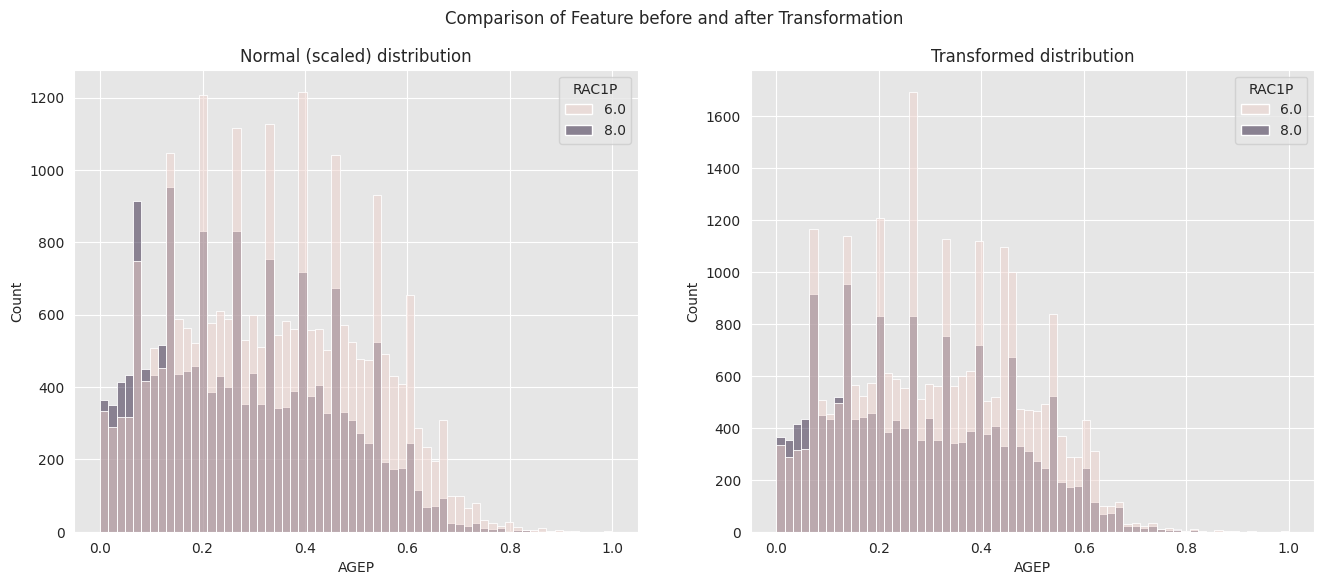

In [27]:
%matplotlib inline

# Initialize figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Set title of figure
fig.suptitle("Comparison of Feature before and after Transformation")

# Set title
ax1.title.set_text("Normal (scaled) distribution")
ax2.title.set_text("Transformed distribution")

# Create plots
sns.histplot(train_aif360.convert_to_dataframe()[0], x="AGEP", hue="RAC1P", ax=ax1)
sns.histplot(df_transform_train, x="AGEP", hue="RAC1P", ax=ax2)
plt.show()

## 3. <a name="3">Train (and Tune) a Classifier</a>
(<a href="#0">Go to top</a>)

We use a Logistic Regression estimator and the transformed data for training. Then we will try to find the best possible repair level.

### 3.1 Model Training

Get the correct training data and corresponding labels. Make sure to delete the sensitive feature before training the model.

In [28]:
# Extract features (and delete sensitive attribute)
X_train = np.delete(train_repd.features, sensitive_attribute_index, axis=1)

# Extract label
y_train = train_repd.labels.ravel()

We train the classifier with `.fit()` on our training dataset. 

In [29]:
# Initialize model
lr = LogisticRegression(solver="lbfgs", penalty="none")

# Train model
lr.fit(X_train, y_train)

# Predict
y_train_pred = lr.predict(X_train)

In [30]:
print("Model performance on the training set:")
print("Training accuracy:", accuracy_score(y_train, y_train_pred))

Model performance on the training set:
Training accuracy: 0.7949974092043902


In [31]:
# Create copy of training dataset and save over the labels with the new predictions
train_repd_pred = train_repd.copy()
train_repd_pred.labels = lr.predict(X_train)

# Create metric
metric = BinaryLabelDatasetMetric(
    train_repd_pred, privileged_groups=priv_group, unprivileged_groups=unpriv_group
).disparate_impact()

In [32]:
print("Model fairness on the training set:")
print("Training DI:", metric)

Model fairness on the training set:
Training DI: 0.25723920758280966


### 3.2 Fairness Tuning

Clearly this is worse than where we started before the transformation. Let's see if we can find the best possible repair level.

In [33]:
# Create list to store DI values at different repair levels
DIs = []

# Loop over different repair levels
for level in tqdm(np.arange(0.0, 1.1, 0.1)):
    # Initialize DI remover
    di = DisparateImpactRemover(repair_level=level)

    # Perform repair
    train_repd = di.fit_transform(train_aif360)
    val_repd = di.fit_transform(val_aif360)

    # Extract features (and delete sensitive attribute)
    X_tr = np.delete(train_repd.features, sensitive_attribute_index, axis=1)
    X_va = np.delete(val_repd.features, sensitive_attribute_index, axis=1)

    # Extract label
    y_tr = train_repd.labels.ravel()
    y_va = val_repd.labels.ravel()

    # Initialize model
    lr = LogisticRegression(solver="lbfgs", penalty="none")

    # Train model
    lr.fit(X_tr, y_tr)

    # Predict with model
    val_repd_pred = val_repd.copy()
    val_repd_pred.labels = lr.predict(X_va)

    # Create metric
    metric = BinaryLabelDatasetMetric(
        val_repd_pred, privileged_groups=priv_group, unprivileged_groups=unpriv_group
    )
    # Append DI value
    DIs.append(metric.disparate_impact())

100%|██████████| 11/11 [02:20<00:00, 12.74s/it]


Let's visualize the repair level and corresponding DI on the validation dataset.

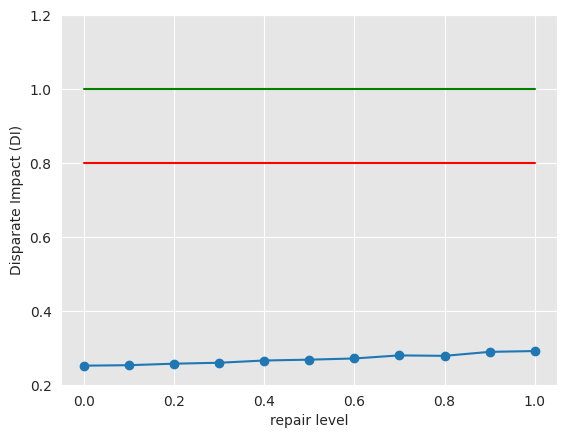

In [34]:
%matplotlib inline
plt.plot(np.arange(0.0, 1.1, 0.1), DIs, marker="o")
plt.plot([0, 1], [1, 1], "g")
plt.plot([0, 1], [0.8, 0.8], "r")
plt.ylim([0.2, 1.2])
plt.ylabel("Disparate Impact (DI)")
plt.xlabel("repair level")
plt.show()

## 4. <a name="4">Test the Classifier</a>
(<a href="#0">Go to top</a>)

Let's now evaluate the performance and fairness of the trained classifier on the test dataset. 

In [35]:
# Transform the test dataset
test_repd = di.fit_transform(test_aif360)

# Extract features and labels from AIF260 dataset construct
X_te = np.delete(test_repd.features, sensitive_attribute_index, axis=1)
y_te = test_repd.labels.ravel()

# Use the last (and most fair) fitted model to make predictions on the test dataset
y_te_pred = lr.predict(X_te)

print("Model performance on the test set:")
print("Test accuracy:", accuracy_score(y_te, y_te_pred))

Model performance on the test set:
Test accuracy: 0.7967933705638623


From our previous notebook, we might remember that the accuracy was around 80%, so pretty much the same as we see above. So far so good, but let's check if the outcomes are fairer on the test set. 

In [36]:
# Predict with model
test_repd_pred = test_repd.copy()
test_repd_pred.labels = y_te_pred

# Create metric
BinaryLabelDatasetMetric(
    test_repd_pred, privileged_groups=priv_group, unprivileged_groups=unpriv_group
).disparate_impact()

0.2948283978569347

This is much lower than the values we had originally (before the transformation when DI was around 0.4). So we are in fact even further away from not having DI impact. Let's wrap up by visualizing this.

In [37]:
# Create dataframe that contains predictions and the sensitive attribute
di_df = pd.concat(
    [
        test_data.reset_index(drop=True)[["RAC1P", ">50k"]],
        pd.Series(y_te_pred, name="y_test_pred"),
    ],
    axis=1,
)

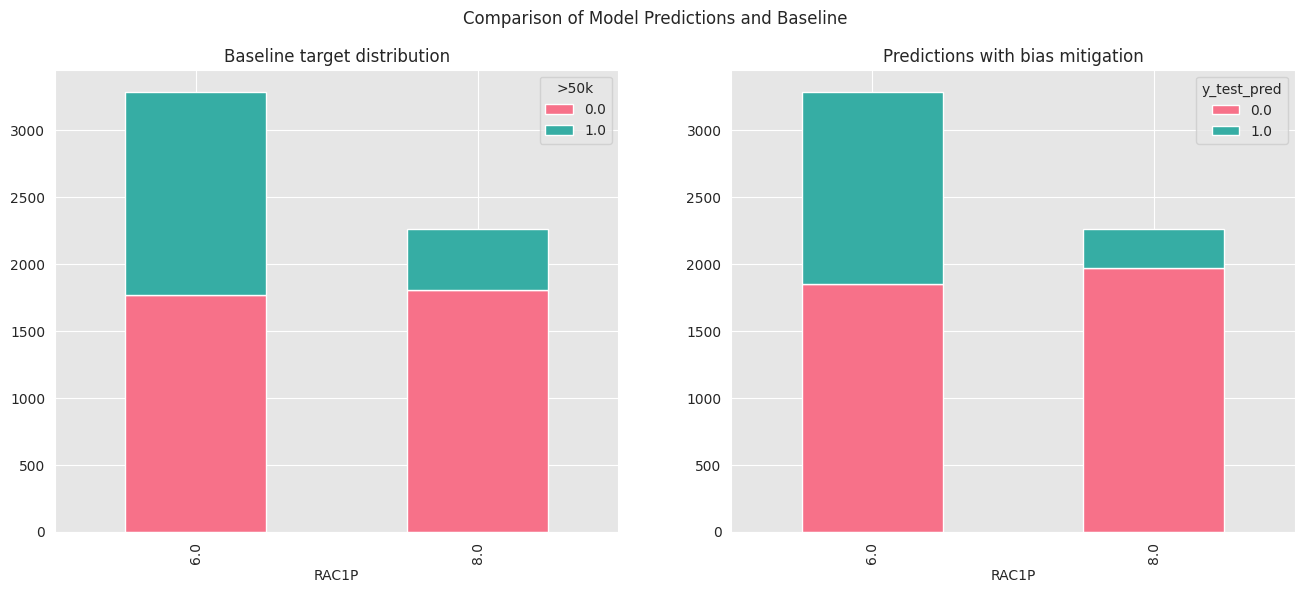

In [38]:
%matplotlib inline
# Initialize figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Set title of figure
fig.suptitle("Comparison of Model Predictions and Baseline")

# Set title
ax1.title.set_text("Baseline target distribution")
ax2.title.set_text("Predictions with bias mitigation")

# Create plots
di_df.groupby(["RAC1P", model_target]).size().unstack().plot(
    kind="bar", stacked=True, color=sns.husl_palette(2), ax=ax1
)
di_df.groupby(["RAC1P", "y_test_pred"]).size().unstack().plot(
    kind="bar", stacked=True, color=sns.husl_palette(2), ax=ax2
)
# Align y-axis
ax2.sharey(ax1)

We notice that the results for the disfavored group have worsened. This could be explained by the fact that we are dealing with an imbalance in the class label itself and outcome '0' will be favored by the model in general. It appears that group 6 does not gain much advantage despite the DI transformation. As final check, we can look at model predictions for the dataset without DI transformation and compare what would have happened if we hadn't intervened.

In [39]:
# Create predictions for the test data without DI transformation
lr.fit(data_processor.transform(train_data), train_data[model_target])
noDI_test_preds = lr.predict(data_processor.transform(test_data))

# Join the predictions to the dataframe we need for plotting
di_df = pd.concat(
    [
        di_df,
        pd.Series(noDI_test_preds, name="y_test_pred_noDI"),
    ],
    axis=1,
)

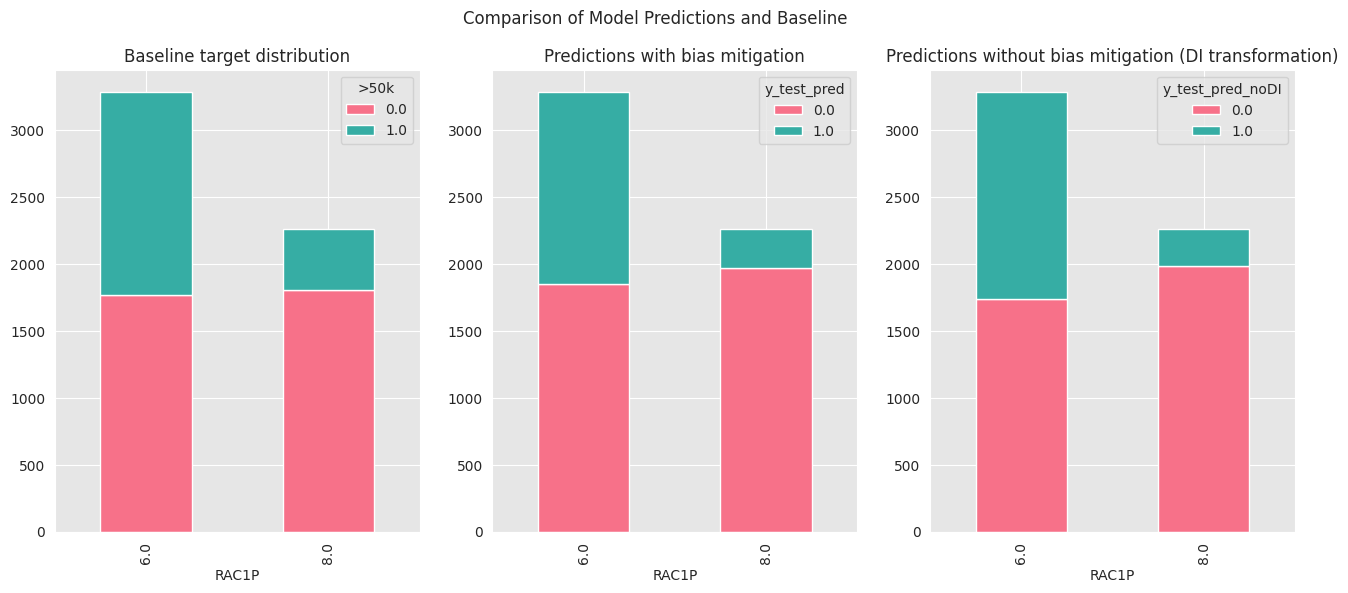

In [40]:
%matplotlib inline
# Initialize figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

# Set title of figure
fig.suptitle("Comparison of Model Predictions and Baseline")

# Set title
ax1.title.set_text("Baseline target distribution")
ax2.title.set_text("Predictions with bias mitigation")
ax3.title.set_text("Predictions without bias mitigation (DI transformation)")

# Create plots
di_df.groupby(["RAC1P", model_target]).size().unstack().plot(
    kind="bar", stacked=True, color=sns.husl_palette(2), ax=ax1
)
di_df.groupby(["RAC1P", "y_test_pred"]).size().unstack().plot(
    kind="bar", stacked=True, color=sns.husl_palette(2), ax=ax2
)
di_df.groupby(["RAC1P", "y_test_pred_noDI"]).size().unstack().plot(
    kind="bar", stacked=True, color=sns.husl_palette(2), ax=ax3
)

# Align y-axis
ax2.sharey(ax1)
ax3.sharey(ax1)

As expected, in the model that was trained without DI remover, group 6 had an even higher number of predictions for the < 50k class and was therefor more unfair. For group 8 we notice that there are slightly fewer positive outcomes when DI transformation is considered. Generally, what we should notice is that while a model might have good accuracy, we still need to check outcome distributions per target class as errors might be disproportionately concentrated in a certain group. For this particular dataset DI removal did not have the desired effect and we should look into other options.

This is the end of this notebook.